# BNS Postmerger GW Representations

This notebook explores the time-, frequency- and time-frequency representations of BNS merger/post-merger signals


In [1]:
# %matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import sys, os, h5py
import numpy as np
from matplotlib import pyplot as plt
import cwt
from scipy.interpolate import interp1d
from skimage.measure import shannon_entropy

import pycbc.waveform as wfutils
from pycbc.waveform import get_td_waveform,taper_timeseries
from pycbc.types import FrequencySeries
from pycbc.filter import sigma as optimal_snr

fig_width_pt = 510.
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fontsize = 16
legendfontsize = 14

params={'text.usetex': True,
        'axes.labelsize': fontsize,
        'text.fontsize': fontsize,
        'legend.fontsize': legendfontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.figsize': fig_size,
        'font.weight': 'normal'
       }


import pylab
pylab.rcParams.update(params)
pylab.rcParams['axes.linewidth'] = 1
pylab.rc('axes', linewidth=1)

def touchbox(ax):
    ax.tick_params('both', length=5, width=1, which='major')
    ax.tick_params('both', length=3.5, width=1, which='minor')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    return


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  mplDeprecation)


## Data aquisition

### Notebook configuration
working & save directories, filenames etc

In [2]:
workdir="/work/BNS-bursts/utils"
waveform_dir="/lvcnr-matter/BNS/bauswein"
waveform_file=os.path.join(waveform_dir,"bauswein-waves.txt")
savepath = "/work"

sample_frequency = 16384

### Waveform configuration
Choice of waveform (filename), EOS, masses, ...
Note that the name convention below only applies to Bauswein waveforms; we'll need a different routine for Trento/Frankfurt

In [3]:
# EOS="NL3"
# mass=(1.9,1.9)

# # Construct waveform label: EOS(lower case)_mass1mass2.h5
# if EOS=="DD2":
#     wavelabel=EOS.lower()+"new_"+"".join(
#         [str(component).replace(".","") for component in mass]
#     )
# else:
#     wavelabel=EOS.lower()+"_"+"".join(
#         [str(component).replace(".","") for component in mass]
#     )

# numrel_data=os.path.join(waveform_dir,wavelabel+'.h5')

# if os.path.exists(numrel_data):
#     print "HDF5 {} located".format(numrel_data)
# else:
#     print "HDF5 {} non-existent".format(numrel_data)
#     sys.exit()

numrel_files = [os.path.join(waveform_dir, waveform)
                for waveform in np.genfromtxt(waveform_file, dtype=str)]
masses = []
for nf in numrel_files:
    massstr = nf.split('/')[-1].replace(".h5","").split("_")[-1]
    if len(massstr)==4:
        mass = (float(massstr[:2])/10,float(massstr[2:])/10)
    elif len(massstr)==6:
        mass = (float(massstr[:3])/100,float(massstr[3:])/100)
    masses.append(mass)


## Generate Waveforms And Time-Frequency Analysis


/work/apr_135135 [1/49]
/work/bhblp_1212 [2/49]
/work/bhblp_135135 [3/49]
/work/bhblp_1515 [4/49]
/work/dd2_1212 [5/49]
/work/dd2_1215 [6/49]
/work/dd2_1314 [7/49]
/work/dd2_135135 [8/49]
/work/dd2_1515 [9/49]
/work/dd2_165165 [10/49]
/work/dd2new_135135 [11/49]
/work/gs2_1212 [12/49]
/work/gs2_1215 [13/49]
/work/gs2_1515 [14/49]
/work/ls220_1212 [15/49]
/work/ls220_1215 [16/49]
/work/ls220_1414 [17/49]
/work/ls220_1515 [18/49]
/work/ls375_1212 [19/49]
/work/ls375_1215 [20/49]
/work/ls375_1515 [21/49]
/work/newheb3_gth167_1515 [22/49]
/work/newheb4_gth167_1515 [23/49]
/work/newheb5_gth167_1515 [24/49]
/work/newheb6_gth167_1515 [25/49]
/work/nl3_1212 [26/49]
/work/nl3_1215 [27/49]
/work/nl3_1314 [28/49]
/work/nl3_135135 [29/49]
/work/nl3_1515 [30/49]
/work/nl3_1818 [31/49]
/work/nl3_1919 [32/49]
/work/sfho_1212 [33/49]
/work/sfho_1314 [34/49]
/work/sfho_135135 [35/49]
/work/sfho_1414 [36/49]
/work/sfhx_1212 [37/49]


KeyboardInterrupt: 

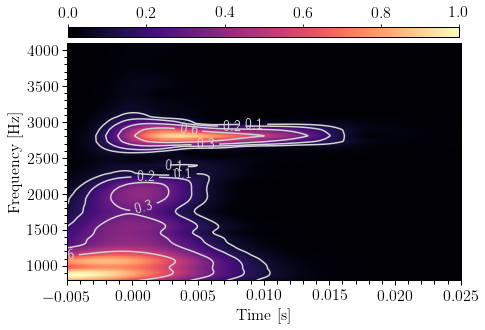

In [4]:
for n,(numrel_data, mass) in enumerate(zip(numrel_files, masses)):
    
    wavelabel=os.path.join(savepath, numrel_data.split('/')[-1].replace(".h5",""))

    print "%s [%d/%d]"%(wavelabel, n+1, len(numrel_files))
      
    f = h5py.File(numrel_data, 'r')

    hp, hc = get_td_waveform(approximant='NR_hdf5',
                                 numrel_data=numrel_data,
                                 mass1=f.attrs['mass1']*sum(mass),
                                 mass2=f.attrs['mass2']*sum(mass),
                                 spin1z=f.attrs['spin1z'],
                                 spin2z=f.attrs['spin2z'],
                                 delta_t=1.0/sample_frequency,
                                 f_lower=10.,
                                 inclination=0.0,
                                 coa_phase=0.0,
                                 distance=100)

    f.close()

#     # Resize / zero-pad to 10 seconds
    hp.resize(10*sample_frequency)
    hc.resize(10*sample_frequency)

    # Truncate and taper from maximum
    delay=0#int(1e-3 / delta_t)
    truncidx = np.argmax(abs(hp)) - delay
    import copy
    hp_post = copy.deepcopy(hp)
    hp_post.data[:truncidx] = 0.0 
    hc_post = copy.deepcopy(hc)
    hc_post.data[:truncidx] = 0.0 

    # taper waveform
    hp = taper_timeseries(hp, tapermethod="TAPER_STARTEND")
    hc = taper_timeseries(hc, tapermethod="TAPER_STARTEND")

    hp_post = taper_timeseries(hp_post, tapermethod="TAPER_STARTEND")
    hc_post = taper_timeseries(hc_post, tapermethod="TAPER_STARTEND")


    # Reduce to 0.25 second
    hp_red = hp[:int(sample_frequency)]

    # User input
    mother_freq=6
    max_scale=128

    fmin=sample_frequency*mother_freq/max_scale
    fmax=sample_frequency*mother_freq


    shannon = []
    Qs=np.arange(0.5, 8, 0.5)
    for q, Q in enumerate(Qs):

        # Compute the CWT
        cwt_result = cwt.build_cwt(hp_red.data, hp_red.sample_times, 
                                   mother_freq=Q, max_scale=max_scale)
        wplane = cwt_result['map']

        shannon.append(shannon_entropy(wplane))

#         print "On Q={0}: {1} [{2}/{3}]".format(Q, shannon[q], q+1, len(Qs))

    plt.figure()
    plt.plot(np.arange(0.5, 8, 0.5), shannon)
    plt.axvline(np.arange(0.5, 8, 0.5)[np.argmax(shannon)], color='r', label=np.arange(0.5, 8, 0.5)[np.argmax(shannon)])
    plt.legend()
    plt.savefig("{}-Entropies.png".format(wavelabel))
    plt.close()


    # Compute the CWT

    red_time = hp_red.sample_times - hp.sample_times[np.argmax(abs(hp_red))]

    cwt_result = cwt.build_cwt(hp_red.data, hp_red.sample_times, 
                               mother_freq=mother_freq, max_scale=max_scale)
    wtimes = np.copy(red_time)
    wfreqs = cwt_result['frequencies']
    wplane = cwt_result['map']

    # Eliminate freqs > Nyquist
    interpolant = interp1d(wfreqs, wplane, axis=0)
    wfreqs = np.arange(wfreqs.min(), 4096, 10)
    wplane = interpolant(wfreqs)



    fig, ax = plt.subplots(figsize=fig_size)

    p_qstrain = ax.pcolormesh(wtimes, wfreqs, (abs(wplane)),
                              cmap='magma', rasterized=False,
                             vmin=0,vmax=1)

    c_qstrain = ax.contour(wtimes, wfreqs, (abs(wplane)), 
                colors='lightgray', levels=np.logspace(-1,0,5))

    cbaxes = fig.add_axes([0.1275, 0.9, 0.77, 0.03]) 
    cbar=fig.colorbar(p_qstrain, orientation='horizontal', cax=cbaxes)

    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    ax.set_xlim(-0.005,0.025)
    ax.set_ylim(800,4096)

    ax.set_xlabel(r'$\textrm{Time [s]}$')
    ax.set_ylabel(r'$\textrm{Frequency [Hz]}$')
    ax.clabel(c_qstrain, inline=1, fmt="%.1f", fontsize=14)
    ax.minorticks_on()

    touchbox(ax)

    plt.savefig("{}-CWT.png".format(wavelabel))
    plt.close()
    
    
    # Savez
    np.savez("{}-map".format(wavelabel), time=wtimes, frequency=wfreqs,
            tfmap=wplane)

#     sys.exit()